## 데이터 수집

In [74]:
from bs4 import BeautifulSoup 
from urllib.request import urlopen
from konlpy.tag import Twitter
from lxml import html
from collections import Counter
from datetime import datetime, timedelta
from selenium import webdriver

import pandas as pd
import re
import random
import pytagcloud      # requires Korean font support
import webbrowser
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time

matplotlib.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
from pylab import figure, axes, pie, title, savefig
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

### 언론사 제목 수집(조선,세계,한겨레)

### URL 입력

In [2]:
urls = []
url = input("url 주소를 입력하세요. \n정치 : http://www.segye.com/newsList/0101010100000?curPage=\n경제 : http://www.segye.com/newsList/0101030100000?curPage=\n사회 : http://www.segye.com/newsList/0101080100000?curPage= \n")
for x in range(1, 1000):
    urls.append('%s%d' % (url, x))

url 주소를 입력하세요. 
정치 : http://www.segye.com/newsList/0101010100000?curPage=
경제 : http://www.segye.com/newsList/0101030100000?curPage=
사회 : http://www.segye.com/newsList/0101080100000?curPage= 
http://www.segye.com/newsList/0101080100000?curPage=


In [3]:
len(urls)

999

In [4]:
urls

['http://www.segye.com/newsList/0101080100000?curPage=1',
 'http://www.segye.com/newsList/0101080100000?curPage=2',
 'http://www.segye.com/newsList/0101080100000?curPage=3',
 'http://www.segye.com/newsList/0101080100000?curPage=4',
 'http://www.segye.com/newsList/0101080100000?curPage=5',
 'http://www.segye.com/newsList/0101080100000?curPage=6',
 'http://www.segye.com/newsList/0101080100000?curPage=7',
 'http://www.segye.com/newsList/0101080100000?curPage=8',
 'http://www.segye.com/newsList/0101080100000?curPage=9',
 'http://www.segye.com/newsList/0101080100000?curPage=10',
 'http://www.segye.com/newsList/0101080100000?curPage=11',
 'http://www.segye.com/newsList/0101080100000?curPage=12',
 'http://www.segye.com/newsList/0101080100000?curPage=13',
 'http://www.segye.com/newsList/0101080100000?curPage=14',
 'http://www.segye.com/newsList/0101080100000?curPage=15',
 'http://www.segye.com/newsList/0101080100000?curPage=16',
 'http://www.segye.com/newsList/0101080100000?curPage=17',
 'http

### 하나의 페이지 테스트

In [5]:
url = urls[0]
html = urlopen(url)
data = BeautifulSoup(html, "lxml")

In [6]:
data

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html lang="ko" xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="세계일보" name="Author"/>
<meta content="세계일보" name="Description"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<link href="//img.segye.com/resourcesimages/favicon-segye1.ico" rel="shortcut icon"/>
<link href="//img.segye.com/resources/css/segye2016.css" rel="stylesheet" type="text/css"/>
<title>세상을 보는 눈, 글로벌 미디어 - 세계일보 -</title>
</head>
<!-- Google Tag Manager -->
<body><noscript><iframe height="0" src="//www.googletagmanager.com/ns.html?id=GTM-KDPKKS" style="display:none;visibility:hidden" width="0"></iframe></noscript>
<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':
new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],
j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'

In [7]:
data_temp = data.find_all('div', 'newslist_area')

In [8]:
len(data_temp)

1

#### 제목 가져오기

In [9]:
data_title = data_temp[0].find_all('dt', 'title_cr')

In [10]:
data_title[0]

<dt class="title_cr"><a href="/newsView/20181119002138" target="_self">"성범죄 재판서 '술마셨다고 형량 감경' 없었다" 분석 발표</a></dt>

In [11]:
data_title[-1]

<dt class="title_cr"><a href="/newsView/20181119000356" target="_self">인생 3할을 수감 생활한 50대, 출소 3일 만에 담 넘다 구속</a></dt>

In [12]:
len(data_title)

20

In [13]:
data_title[0].get_text()

'"성범죄 재판서 \'술마셨다고 형량 감경\' 없었다" 분석 발표'

In [14]:
re.sub('[\'\n\r\t\xa0]', '', data_title[0].get_text())

'"성범죄 재판서 술마셨다고 형량 감경 없었다" 분석 발표'

#### 날짜 가져오기

In [15]:
data_date = data_temp[0].find_all('span', 'date')

In [16]:
data_date[0]

<span class="date">2018.11.19</span>

In [17]:
data_date[-1]

<span class="date">2018.11.19</span>

In [18]:
len(data_date)

20

In [19]:
data_date[0].get_text()

'2018.11.19'

### 데이터 수집 및 확인

### 언론사(세계)

In [21]:
title = []
date = []
page = 0

start_flag = False
end_flag = False

end_date = input("시작 날짜를 입력하세요.  ex) 20181007 \n")
start_date = input("마지막 날짜를 입력하세요.  ex) 20181115 \n")
end_date = end_date[:4] + '.' + end_date[4:6] + '.' + end_date[6:]
start_date = start_date[:4] + '.' + start_date[4:6] + '.' + start_date[6:]

print("=" * 50)
print("[%s ~ %s] 데이터 수집을 시작합니다.\n" % (end_date, start_date))

start = datetime.now()

for url in urls:
    html = urlopen(url)
    data = BeautifulSoup(html, "lxml")    
    data_temp = data.find_all('div', 'newslist_area')
    
    # 기사 제목 및 날짜 찾기
    data_title = data_temp[0].find_all('dt', 'title_cr')
    data_date = data_temp[0].find_all('span', 'date')
    
    # 데이터수집 체크
    page += 1
    
    if start_flag:
        print("%d 페이지 수집중입니다.... ing" %page, end='')
    
    for x in range(len(data_title)):
        
        # 기사 끝날 날짜 체크 (end_flag 변경)
        if data_date[x].get_text() in end_date:
            temp_date = data_date[x].get_text()
            end_flag = True

        # 기사 끝날 날짜 체크(반복문 out)    
        if end_flag:
            if not(temp_date == data_date[x].get_text()):
                break       
        
        
        if not(start_flag):            
            # 기사 시작 날짜 체크
            if not(data_date[x].get_text() in start_date):            
                continue
            print("%d 페이지 수집중입니다.... ing" %page, end='')
            start_flag = True
        
  
        
        # 기사 제목만 가져오기
        title.append(re.sub('[\'\n\r\t\xa0]', '', data_title[x].get_text()))
   
        # 기사 날짜만 가져오기
        date.append(data_date[x].get_text())
        

    # 데이터 수집 시작 체크
    if not(start_flag):
        continue
        
    # 데이터수집 체크
    print("     [수집완료]")       
          
    
    # 기사 끝날 날짜 체크(반복문 out)  
    if end_flag:
        if not(temp_date == data_date[x].get_text()):
            break 

        
end = datetime.now()
print("=" * 50)
print("데이터 수집을 완료했습니다.")
elapsed = end - start
print('총 계산 시간: ', end='');   print(elapsed)
print('총 수집 개수: %d개' %len(title))

시작 날짜를 입력하세요.  ex) 20181007 
20181111
마지막 날짜를 입력하세요.  ex) 20181115 
20181117
[2018.11.11 ~ 2018.11.17] 데이터 수집을 시작합니다.

4 페이지 수집중입니다.... ing     [수집완료]
5 페이지 수집중입니다.... ing     [수집완료]
6 페이지 수집중입니다.... ing     [수집완료]
7 페이지 수집중입니다.... ing     [수집완료]
8 페이지 수집중입니다.... ing     [수집완료]
9 페이지 수집중입니다.... ing     [수집완료]
10 페이지 수집중입니다.... ing     [수집완료]
11 페이지 수집중입니다.... ing     [수집완료]
12 페이지 수집중입니다.... ing     [수집완료]
13 페이지 수집중입니다.... ing     [수집완료]
14 페이지 수집중입니다.... ing     [수집완료]
15 페이지 수집중입니다.... ing     [수집완료]
16 페이지 수집중입니다.... ing     [수집완료]
17 페이지 수집중입니다.... ing     [수집완료]
18 페이지 수집중입니다.... ing     [수집완료]
19 페이지 수집중입니다.... ing     [수집완료]
20 페이지 수집중입니다.... ing     [수집완료]
21 페이지 수집중입니다.... ing     [수집완료]
22 페이지 수집중입니다.... ing     [수집완료]
23 페이지 수집중입니다.... ing     [수집완료]
24 페이지 수집중입니다.... ing     [수집완료]
25 페이지 수집중입니다.... ing     [수집완료]
26 페이지 수집중입니다.... ing     [수집완료]
27 페이지 수집중입니다.... ing     [수집완료]
28 페이지 수집중입니다.... ing     [수집완료]
29 페이지 수집중입니다.... ing     [수집완료]
데이터 수집을 완료했습니다.
총 계산 시간: 0:00

In [ ]:
len(title)

In [ ]:
len(date)

In [24]:
title[0]

'"재미 삼아 기절시켰다"…거제 학교폭력 가해자 처벌 청원'

In [25]:
date[0]

'2018.11.17'

In [26]:
title[-1]

'유전무죄 무전유죄…법 지키면 손해인 대한민국? [김현주의 일상 톡톡]'

In [27]:
date[-1]

'2018.11.11'

### DataFrame 만들기 & 파일로 저장하기

In [28]:
df_temp = {'Title' : title, 'Date' : date}
df = pd.DataFrame(df_temp)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 2 columns):
Title    495 non-null object
Date     495 non-null object
dtypes: object(2)
memory usage: 7.8+ KB


In [30]:
df.head(10)

,Title,Date
0,"""재미 삼아 기절시켰다""…거제 학교폭력 가해자 처벌 청원",2018.11.17
1,"전해철 혜경궁 김씨경찰수사 결과에 ""고발 취하했는데 결과 나오니 당황스러운 마음 뿐""",2018.11.17
2,‘혜경궁 김씨’ 밝혀낸 누리꾼들…이재명도 “누리꾼 도와달라”,2018.11.17
3,"충북 청주 한 아파트서 30대 남성, 아내 살해 후 유서 남기고 투신 사망",2018.11.17
4,"양구 군인 사망 軍 대공혐의 없다에 누리꾼""사망원인 규명 안됐는데 북한 소행부터 원...",2018.11.17
5,"""혜경궁 김씨는 이재명 부인""… 논란 일파만파",2018.11.17
6,시민단체·학무보 “유치원생·학부모가 호구?”… 한국당에 ‘경고’,2018.11.17
7,“학교 밖 청소년 향한 이해와 배려 절실”,2018.11.17
8,“경찰이면 다냐”… 경찰관 급소 가격한 30대,2018.11.17
9,가정폭력 피해 쉼터 왔는데… 사회는 문제아 낙인,2018.11.17


In [31]:
df.tail(10)

,Title,Date
485,음주운전 안된다 경종 울리고 떠나…윤창호씨 영결식,2018.11.11
486,"차한성·김기춘, 10년 만에 인연에서 악연으로",2018.11.11
487,광주형 일자리 협상 15일 데드라인…현대차·노동계 설득 총력,2018.11.11
488,"한때는 범법자, 이제는 봉사왕…""사회봉사가 나를 바꿨다""",2018.11.11
489,"""여자 불러줄게""… 모텔 따라가 탈탈 털린 남성들",2018.11.11
490,“마약 거래에 성범죄물도 넘실”…다크웹 속엔 또다른 ‘워마드’가 있다,2018.11.11
491,"불법 온상 다크웹…한국, 더이상 무풍지대 아니다",2018.11.11
492,"""스마트폰 그만 보세요""…위험천만 산행 스몸비",2018.11.11
493,고교 무상급식 놓고…부산시-기장군의 진실게임,2018.11.11
494,유전무죄 무전유죄…법 지키면 손해인 대한민국? [김현주의 일상 톡톡],2018.11.11


### 결과 저장하기(주석 처리)

In [32]:
# Thema = input("주제를 입력하세요.  ex) society \n")
# df.to_csv('TeamMission/segye_%s_title_(%s - %s).csv' % (Thema, end_date, start_date), sep=',', encoding='UTF-8')

## 기사 단어 뽑기

### 저장된 데이터 가져오기

In [36]:
check = input("언론사 데이터를 가져오려면 : 1 \n국민청원 데이터를 가져오려면 : 2\n")

if check == "1":
    Thema = input("주제를 입력하세요.  ex) society \n")
    end_date = input("시작 날짜를 입력하세요.  ex) 20181007 \n")
    start_date = input("마지막 날짜를 입력하세요.  ex) 20181115 \n")
    choose = input("제목만 가져오려면 : 1\n본문까지 가져오려면 : 2 \n")
    end_date = end_date[:4] + '.' + end_date[4:6] + '.' + end_date[6:]
    start_date = start_date[:4] + '.' + start_date[4:6] + '.' + start_date[6:]
else:
    thema = input("청원 분야를 입력하세요.\n- 일교/통일/국방 : 36 \n- 일자리 : 37 \n- 인권/성평등 : 49 \n")
    day = input("진행 중 청원 : 1, 만료된 청원 : 2, 전체 청원 : 3\n")
    end_date = input("시작 날짜를 입력하세요.  ex) 181007 \n")
    start_date = input("마지막 날짜를 입력하세요.  ex) 181115 \n")
    end_date = end_date[:2] + '.' + end_date[2:4] + '.' + end_date[4:]
    start_date = start_date[:2] + '.' + start_date[2:4] + '.' + start_date[4:]

언론사 데이터를 가져오려면 : 1 
국민청원 데이터를 가져오려면 : 2
1
주제를 입력하세요.  ex) society 
economy
시작 날짜를 입력하세요.  ex) 20181007 
20180101
마지막 날짜를 입력하세요.  ex) 20181115 
20180331
제목만 가져오려면 : 1
본문까지 가져오려면 : 2 
1


In [37]:
if check == "1":
    if choose == '1':
        word = pd.read_csv('./TeamMission/segye_%s_title_(%s - %s).csv' % (Thema, end_date, start_date), sep=',', encoding='utf-8')
    else:
        word = pd.read_csv('./TeamMission/segye_%s_(%s - %s).csv' % (Thema, end_date, start_date), sep=',', encoding='utf-8')
else:
    word = pd.read_csv('./TeamMission/president_%s_%s_(%s - %s).csv' % (thema, day, end_date, start_date), sep=',', encoding='utf-8')

del word['Unnamed: 0']

In [38]:
word.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451 entries, 0 to 2450
Data columns (total 2 columns):
Title    2451 non-null object
Date     2451 non-null object
dtypes: object(2)
memory usage: 38.4+ KB


In [39]:
word.head(10)

,Title,Date
0,"[일상톡톡 플러스] ""자취 감췄던 전세매물 갑자기 쏟아지는 까닭은?""",2018.03.31
1,"[출발부터 마이너스-상] ""학자금 대출 상환 부담…취업해도 남는 게 없네""",2018.03.31
2,[출발부터 마이너스-하] 결혼하느라 빚 지고…육아휴직하니 소득 줄어,2018.03.31
3,재건축 초과이익환수제는 헌법 위반일까,2018.03.31
4,[스타벅스 탐구②] “국내 커피시장 상생 위해 더 노력”,2018.03.31
5,[스타벅스 탐구①] 커피 공화국 사람들이 스타벅스로 가는 이유는,2018.03.31
6,[김현주의 일상 톡톡] 국가부채 1500조원 시대 공무원연금 논란 진실은?,2018.03.31
7,"한우자조금, 신규 캐릭터 ‘한우패밀리’ 네이밍 공모전 개최",2018.03.31
8,"금호타이어 노조, 해외매각 수용… 회생 발판 마련",2018.03.30
9,"금호타이어 노사, 9인 긴급 간담회서 해외매각 합의",2018.03.30


In [40]:
word.tail(10)

,Title,Date
2441,"[일상톡톡 플러스] ""회사는 전쟁터, 밖은 지옥…이직 확정 전 사직서 쓰지 마라?""",2018.01.01
2442,[2018 새해특집] 금리 한두 차례 인상 가능성… 중위험·중수익 전략을,2018.01.01
2443,"[2018 새해특집] 금·달러, 대안 투자로 20∼30% 보유 바람직",2018.01.01
2444,"글로벌 기업 KT&G, 해외 사회공헌 ‘활발’",2018.01.01
2445,[4차 산업혁명 파고-산업계 무인화 가속] 창의성·문제해결능력 갖춘 미래 인재 키운다,2018.01.01
2446,[4차 산업혁명 파고-산업계 무인화 가속] 인간의 일터 잠식하는 AI … ‘일자리 ...,2018.01.01
2447,작년 수출 5천739억달러 사상최대…반도체 수출 첫 900억달러,2018.01.01
2448,무술년 황금 개의 해…개띠 금융 CEO은 누구?,2018.01.01
2449,[김현주의 일상 톡톡] 롱패딩 열풍…미니스커트가 미소 짓는다고?,2018.01.01
2450,[이코노 브리핑] 한국GM 노사 임금협상 잠정 합의 외,2018.01.01


In [41]:
len(word)

2451

#### DataFrame -> List -> String

In [42]:
words = str()

start = datetime.now()

if check == '1':
    if choose == '1':
        for i in range(len(list(word['Title']))):
            words += str(list(word['Title'])[i])
    else:
        for i in range(len(list(word['News']))):
            words += str(list(word['News'])[i])
else:
    for i in range(len(list(word['Title']))):
        words += str(list(word['Title'])[i])

end = datetime.now()
elapsed = end - start
print('총 계산 시간: ', end='');   print(elapsed)

총 계산 시간: 0:00:00.234014


In [43]:
words[:1000]

'[일상톡톡 플러스] "자취 감췄던 전세매물 갑자기 쏟아지는 까닭은?"[출발부터 마이너스-상] "학자금 대출 상환 부담…취업해도 남는 게 없네"[출발부터 마이너스-하] 결혼하느라 빚 지고…육아휴직하니 소득 줄어재건축 초과이익환수제는 헌법 위반일까[스타벅스 탐구②] “국내 커피시장 상생 위해 더 노력”[스타벅스 탐구①] 커피 공화국 사람들이 스타벅스로 가는 이유는[김현주의 일상 톡톡] 국가부채 1500조원 시대 공무원연금 논란 진실은?한우자조금, 신규 캐릭터 ‘한우패밀리’ 네이밍 공모전 개최금호타이어 노조, 해외매각 수용… 회생 발판 마련금호타이어 노사, 9인 긴급 간담회서 해외매각 합의금호타이어 노사 "더블스타 자본유치 합의"금호타이어 노사정-채권단 해외매각 합의안 극적 타결김상조 공정위원장 "경제환경 변화 반영한 공정거래법 전면 개편 추진"LG전자 협력회 정기총회…동반성장성과공유·시상식건물마다 임대 문구… 빈 점포 느는 청담·압구정 상권현대중공업지주 본격 출범…대표이사에 권오갑 부회장2월 소비·투자 증가세 이어져정부 압박·싸늘한 여론… 금호타이어 해외매각 어떻게 되나재벌 저격수 금감원장 등장… 금융시장 살얼음판제7회 수산인의 날…"깨끗한 바다, 풍요로운 어장 회복하자"김영문 관세청장, 국제이사화물 통관센터 현장 점검[일상톡톡 플러스] "OO대게, 산지 가서 먹어도 비싸다?"긴급 간담회 금호타이어 정상화 분수령이총리 "대기업 일감몰아주기·편법승계 막도록 제도화할 것"초특가 항공권 구매하고 코나커피 받자…세일여행사 창립 33주년 기념 감사 이벤트금리 인하 덕에 한은 작년 순익 4조 육박…16년 만에 최대금호타이어 노조, 해외매각 조합원 찬반투표 결정흙수저는 결국 흙수저…빈곤 탈출 확률 점점 떨어져금호타이어 노조, 해외 매각 조합원 찬반투표…贊이면 더블스타, 反이면 법정관리"콘크리트 건물로 피신"…톈궁 1호 추락시 행동요령은한국GM 노사 임단협 교섭 결렬…"자금난 타개 어려워졌다"금호타이어 노조, 해외매각 조합원 찬반투표 결정건물마다 빈 점포 속출…청담동·압구정에

In [44]:
len(words)

71575

#### 트위터로 단어 뽑기

In [45]:
start = datetime.now()

twitter = Twitter()
nouns3 = twitter.nouns(words)
count3 = Counter(nouns3)

end = datetime.now()
elapsed = end - start
print('총 계산 시간: ', end='');   print(elapsed)

C:\python\Anaconda3-52\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


총 계산 시간: 0:00:11.355649


#### 단어 분류

In [46]:
one_words = []
two_words = []
etc_words = []

for noun in nouns3:
    if len(noun) == 1:
        one_words.append(noun)
    elif len(noun) == 2:
        two_words.append(noun)
    else:
        etc_words.append(noun)
        
len(one_words), len(two_words), len(etc_words)

(2217, 12437, 3393)

In [47]:
one_words = list(set(one_words))
two_words = list(set(two_words))
etc_words = list(set(etc_words))

len(one_words), len(two_words), len(etc_words)

(380, 3204, 1353)

In [48]:
for word in one_words:
    print(word, end='\t')

윤	잔	창	팩	늘	그	피	몸	며	경	닉	쏙	첫	정	워	싹	땅	저	암	던	땀	명	탓	점	객	보	달	악	판	죄	숨	사	볼	텍	철	곤	포	뭘	데	뜻	젠	웬	꿀	현	과	봄	향	폐	더	랩	킥	글	속	치	멍	갑	직	걸	초	율	군	꿈	이	드	쉰	쇼	탈	각	역	두	캣	임	낼	개	월	게	좀	담	융	통	호	차	망	집	몫	급	떼	션	관	식	손	락	류	힘	죽	틈	뚝	익	별	샵	료	공	날	쌀	샘	만	을	쉬	늦	컴	톱	반	로	딸	국	능	덕	폭	붐	번	턴	불	돈	거	행	밖	신	주	칼	너	트	층	원	끼	것	스	면	코	오	혈	최	덫	여	발	설	디	작	변	안	맘	황	활	휘	캔	품	특	제	배	굿	킴	빈	흙	상	못	총	민	형	햄	후	럼	액	벌	펜	닛	자	령	병	족	벽	낙	짓	앱	빅	끌	규	셀	헬	녀	절	소	둘	전	잡	밸	의	유	택	알	독	밤	셋	늪	률	단	투	옆	쭉	새	놈	또	빵	폰	중	렉	핸	빚	접	셈	충	나	마	떡	숲	노	왜	편	값	억	적	약	곧	산	듯	술	널	남	린	밑	홍	바	검	티	살	팔	엠	내	꼭	밍	등	봉	뿔	킹	풀	처	쥐	박	길	델	뉴	앞	난	항	뿐	심	론	세	콕	네	일	재	뒤	권	딜	확	곳	위	콩	쾌	질	매	존	업	문	츠	뻔	숍	키	팬	척	어	계	실	줄	쌍	고	종	촌	터	교	강	량	부	눈	생	함	욜	도	구	납	법	콘	비	목	분	해	돌	연	찬	런	맛	버	채	수	퍼	준	홈	꺽	외	메	타	답	책	인	열	웨	큐	물	리	땐	뭐	띤	카	및	기	용	겸	폴	딥	간	끝	팀	때	회	무	핀	년	태	말	친	애	베	삶	예	블	금	링	턱	선	감	시	장	건	청	은	방	짐	닭	김	범	퇴	

#### stop_words 생성

In [49]:
stop_words = []
sw_time = ['오늘', '어제', '미래', '내일', '시작', '하루', '올해', '오전', '오후', '하루', '이번', '다시', '마지막','개월', '내년']
sw_various = ['알림','소식', '궂긴', '기업', '회장','최대','대통령','한국','청와대','대표','포토','의원','정부','정치','후보','추진','이유','달라','만난','누구','사진','직접','마련','리선']
sw_region = ['서울','인천','수원','용인','대전','대구','부산','울산','광주','제주','제주도']

stop_words.extend(one_words)
stop_words.extend(sw_time)
stop_words.extend(sw_various)
stop_words.extend(sw_region)
stop_words.extend(one_words)

#### stop_words 빼기

In [50]:
nouns = [word for word in nouns3 if word not in stop_words]
len(nouns)

15169

In [51]:
common_word2 = Counter(nouns)

In [52]:
common_word2 = common_word2.most_common()

In [53]:
wordname = []
wordfreq = []

for i in range(len(common_word2)):
    wordname.append(common_word2[i][0])
    wordfreq.append(common_word2[i][1])
    
    ecolist = pd.DataFrame({'단어명' : wordname, '빈도수':wordfreq})

In [54]:
ecolist.head()

,단어명,빈도수
0,가상,113
1,화폐,110
2,톡톡,81
3,일상,79
4,삼성,72


#### stop_word 실행한 데이터 저장

In [55]:
if check == "1":
    if choose == "1":
        ecolist.to_csv('./TeamMission/segye_%s_title_word_utf_(%s - %s).csv'% (Thema, end_date, start_date), sep=',', encoding='utf-8')
        print('./TeamMission/segye_%s_title_word_utf_(%s - %s).csv 파일을 생성했습니다.'% (Thema, end_date, start_date))
    else:
        ecolist.to_csv('./TeamMission/segye_%s_word_utf_(%s - %s).csv'% (Thema, end_date, start_date), sep=',', encoding='utf-8')
        print('./TeamMission/segye_%s_word_utf_(%s - %s).csv 파일을 생성했습니다.'% (Thema, end_date, start_date))
else:
    ecolist.to_csv('TeamMission/president_%s_%s_word_utf_(%s - %s).csv'% (thema, day, end_date, start_date), sep=',', encoding='utf-8')
    print('TeamMission/president_%s_%s_word_utf_(%s - %s).csv 파일을 생성했습니다.'% (thema, day, end_date, start_date))
    

./TeamMission/segye_economy_title_word_utf_(2018.01.01 - 2018.03.31).csv 파일을 생성했습니다.


#### 워드클라우드 만들기

In [56]:
token = nltk.Text(nouns, name='기사')
type(token), len(token)

(nltk.text.Text, 15169)

In [57]:
token.vocab().most_common(30)

[('가상', 113),
 ('화폐', 110),
 ('톡톡', 81),
 ('일상', 79),
 ('삼성', 72),
 ('타이어', 69),
 ('인상', 69),
 ('코노', 68),
 ('브리핑', 68),
 ('금호', 64),
 ('투자', 64),
 ('최저임금', 64),
 ('일자리', 62),
 ('지원', 62),
 ('김동연', 59),
 ('시장', 58),
 ('금융', 57),
 ('해외', 54),
 ('경영', 51),
 ('롯데', 50),
 ('금리', 49),
 ('수출', 48),
 ('관세', 48),
 ('사업', 47),
 ('특집', 47),
 ('최고', 45),
 ('사회', 44),
 ('플러스', 43),
 ('산업', 42),
 ('은행', 42)]

#### 워드클라우드 한글폰트 설정

In [58]:
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [59]:
data = token.vocab().most_common(1000)
len(data)

1000

In [60]:
data[:10]

[('가상', 113),
 ('화폐', 110),
 ('톡톡', 81),
 ('일상', 79),
 ('삼성', 72),
 ('타이어', 69),
 ('인상', 69),
 ('코노', 68),
 ('브리핑', 68),
 ('금호', 64)]

#### data를 딕셔너리 형태로 변환

In [61]:
dict_data = dict(data)
len(dict_data)

1000

#### 워드클라우드 그리기

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

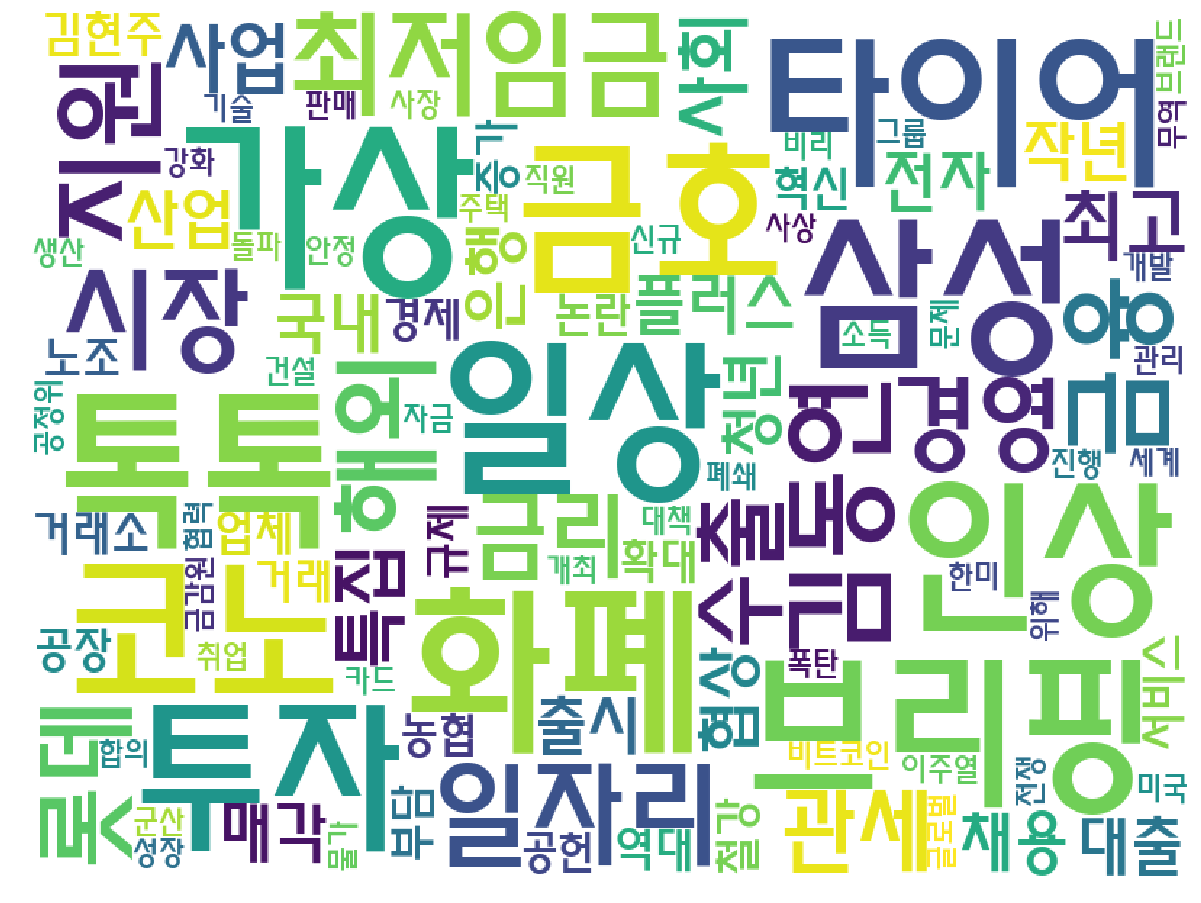

In [63]:
params = {
    "width"            : 800,
    "height"           : 600,
    "min_font_size"    : 2**3, 
    "max_font_size"    : 2**7, 
    "max_words"        : 100,
    "relative_scaling" : 0.2,
#     "font_path"        : 'C:/Windows/Fonts/malgun.ttf',
    "font_path"        : 'C:/Windows/Fonts/HMFMMUEX.TTC',
    "background_color" : 'white',
}

wordcolud = WordCloud(**params)
# wordcolud = wordcolud.generate(text) 
wordcolud = wordcolud.generate_from_frequencies(dict_data) 

if check == '1':
    if choose == '1':
        save_img = 'images/segye_%s_title_wordcloud_(%s - %s).png' % (Thema, end_date, start_date)
    else:
        save_img = 'images/segye_%s_wordcloud_(%s - %s).png' % (Thema, end_date, start_date)
else:
    save_img = 'images/president_%s_%s_(%s - %s).png' % (thema, day, end_date, start_date)
    
plt.figure(figsize=(24,16))
plt.imshow(wordcolud)
plt.axis('off')
plt.savefig(save_img)

## 국민청원 크롤링하기

#### 국민청원 분야별 게시판 주소
- 외교/통일/국방 : 36
- 일자리 : 37
- 인권/성평등 : 49

In [70]:
urls = []
thema = input("크롤링할 청원 분야를 입력하세요.\n- 일교/통일/국방 : 36 \n- 일자리 : 37 \n- 인권/성평등 : 49 \n")
day = input("진행 중 청원 : 1, 만료된 청원 : 2 \n")
for x in range(1, 2000):
    urls.append('https://www1.president.go.kr/petitions/category?c=%s&only=%s&page=%d&order=1' % (thema, day, x))

크롤링할 청원 분야를 입력하세요.
- 일교/통일/국방 : 36 
- 일자리 : 37 
- 인권/성평등 : 49 
36
진행 중 청원 : 1, 만료된 청원 : 2 
1


In [71]:
len(urls)

1999

In [72]:
urls[0]

'https://www1.president.go.kr/petitions/category?c=36&only=1&page=1&order=1'

### 데이터 수집 및 확인

In [75]:
title = []
date = []
count = []
page = 0

start_flag = False
end_flag = False

end_date = input("시작 날짜를 입력하세요.  ex) 181007 \n")
start_date = input("마지막 날짜를 입력하세요.  ex) 181115 \n")
end_date = end_date[:2] + '.' + end_date[2:4] + '.' + end_date[4:]
start_date = start_date[:2] + '.' + start_date[2:4] + '.' + start_date[4:]

print("=" * 50)
print("[%s ~ %s] 국민청원 데이터를 수집합니다.\n" % (end_date, start_date))

start = datetime.now()

# 가상 드라이버 시작
driver_path = "driver/chromedriver.exe"
driver = webdriver.Chrome(executable_path=driver_path)
time.sleep(1)

for url in urls:
    time.sleep(3)
    # url 이동 및 html 소스 수집
    driver.get(url)
    time.sleep(2)
    data = BeautifulSoup(driver.page_source, "lxml")
    time.sleep(2)    

    
    # 청원 데이터 찾기
    data_list = data.find('ul', 'petition_list').find_all('li')

    
    # 데이터 수집 체크
    page += 1

    if len(data_list) == 0:
        break
        
    if start_flag:
        print("%d 페이지 수집중입니다.... ing" %page, end='')
        
    for x in range(len(data_list)):
        
        # 기사 끝날 날짜 체크 (end_flag 변경)
        if data_list[x].find('div', 'bl_date light').get_text()[5:13] in end_date:
            temp_date = data_list[x].find('div', 'bl_date light').get_text()[5:13]
            end_flag = True
               

        # 기사 끝날 날짜 체크(반복문 out)    
        if end_flag:
            if not(temp_date == data_list[x].find('div', 'bl_date light').get_text()[5:13]):
                break       
        
        
        if not(start_flag):            
            # 기사 시작 날짜 체크                                                                      
            if not(data_list[x].find('div', 'bl_date light').get_text()[5:13] in start_date):            
                continue
            print("%d 페이지 수집중입니다.... ing" %page, end='')
            start_flag = True        
          
        # 청원 제목만 가져오기
        title.append(data_list[x].find('a', 'cb relpy_w').get_text()[3:])
   
        # 청원 날짜만 가져오기
        date.append(data_list[x].find('div', 'bl_date light').get_text()[5:13])
        
        # 청원 참여인원 가져오기
        count.append(data_list[x].find('div', 'bl_agree cs').get_text()[5:])
    
    # 데이터 수집 시작 체크
    if not(start_flag):
        continue

        
    # 데이터수집 체크
    print("     [수집완료]")       

    
    # 기사 끝날 날짜 체크(반복문 out)  
    if end_flag:
        if not(temp_date == data_list[x].find('div', 'bl_date light').get_text()[5:13]):
            break 

        
end = datetime.now()
print("=" * 50)
print("데이터 수집을 완료했습니다.")
elapsed = end - start
print('총 계산 시간: ', end='');   print(elapsed)
print('총 수집 개수: %d개' %len(title))    

시작 날짜를 입력하세요.  ex) 181007 
181111
마지막 날짜를 입력하세요.  ex) 181115 
181117
[18.11.11 ~ 18.11.17] 국민청원 데이터를 수집합니다.

10 페이지 수집중입니다.... ing     [수집완료]
11 페이지 수집중입니다.... ing     [수집완료]
12 페이지 수집중입니다.... ing     [수집완료]
13 페이지 수집중입니다.... ing     [수집완료]
14 페이지 수집중입니다.... ing     [수집완료]
15 페이지 수집중입니다.... ing     [수집완료]
16 페이지 수집중입니다.... ing     [수집완료]
17 페이지 수집중입니다.... ing     [수집완료]
18 페이지 수집중입니다.... ing     [수집완료]
19 페이지 수집중입니다.... ing     [수집완료]
20 페이지 수집중입니다.... ing     [수집완료]
21 페이지 수집중입니다.... ing     [수집완료]
22 페이지 수집중입니다.... ing     [수집완료]
23 페이지 수집중입니다.... ing     [수집완료]
24 페이지 수집중입니다.... ing     [수집완료]
25 페이지 수집중입니다.... ing     [수집완료]
26 페이지 수집중입니다.... ing     [수집완료]
27 페이지 수집중입니다.... ing     [수집완료]
28 페이지 수집중입니다.... ing     [수집완료]
29 페이지 수집중입니다.... ing     [수집완료]
30 페이지 수집중입니다.... ing     [수집완료]
31 페이지 수집중입니다.... ing     [수집완료]
32 페이지 수집중입니다.... ing     [수집완료]
33 페이지 수집중입니다.... ing     [수집완료]
34 페이지 수집중입니다.... ing     [수집완료]
35 페이지 수집중입니다.... ing     [수집완료]
36 페이지 수집중입니다.... ing     [수집완료]


KeyboardInterrupt: 

In [ ]:
len(title)

In [ ]:
len(date)

In [ ]:
len(count)

In [ ]:
title[0]

In [ ]:
date[0]

In [ ]:
count[0]

In [ ]:
title[-1]

In [ ]:
date[-1]

In [ ]:
count[-1]

### DataFrame 만들기 & 파일로 저장하기

In [ ]:
df_temp = {'Title' : title, 'Date' : date, 'count' : count}
df = pd.DataFrame(df_temp)

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.to_csv('TeamMission/president_%s_%s_(%s - %s).csv' % (thema, day, end_date, start_date), sep=',', encoding='UTF-8')
print('TeamMission/president_%s_%s_(%s - %s).csv 파일을 생성했습니다.' % (thema, day, end_date, start_date))      

### 국민청원 데이터 정리

#### 데이터 읽어오기

In [2]:
president_36_1 = pd.read_csv('./TeamMission/president_36_1_(18.01.01 - 18.11.16).csv', sep=(','), encoding='utf-8')
president_36_2 = pd.read_csv('./TeamMission/president_36_2_(18.01.01 - 18.10.17).csv', sep=(','), encoding='utf-8')
president_37_1 = pd.read_csv('./TeamMission/president_37_1_(18.01.01 - 18.11.16).csv', sep=(','), encoding='utf-8')
president_37_2 = pd.read_csv('TeamMission/president_37_2_(18.01.01 - 18.11.16).csv', sep=(','), encoding='utf-8')
president_49_1 = pd.read_csv('./TeamMission/president_49_1_(18.01.01 - 18.11.16).csv', sep=(','), encoding='utf-8')
president_49_2 = pd.read_csv('TeamMission/president_49_2_(18.01.01 - 18.11.16).csv', sep=(','), encoding='utf-8')

In [3]:
president_36_1.head()

,Unnamed: 0,Title,Date,count
0,0,북한은매번 일본한테 과거사 과거사 사죄요구합니다..,18.11.16,5명
1,1,문재인 대통령님 국방부 분들 의경 경찰청 없앨거면 군대복무기간 12개월이하로 줄여주세요,18.11.16,2명
2,2,양구 군인 총상 사고 진상규명하십시오.,18.11.16,102명
3,3,옥류관 냉면정치...성공할까???,18.11.16,4명
4,4,중국강경대응,18.11.16,3명


#### 불필요한 열 제거

In [4]:
president_36_1.drop('Unnamed: 0',axis=1, inplace=True)
president_36_2.drop('Unnamed: 0',axis=1, inplace=True)
president_37_1.drop('Unnamed: 0',axis=1, inplace=True)
president_37_2.drop('Unnamed: 0',axis=1, inplace=True)
president_49_1.drop('Unnamed: 0',axis=1, inplace=True)
president_49_2.drop('Unnamed: 0',axis=1, inplace=True)

In [5]:
president_36_1.head()

,Title,Date,count
0,북한은매번 일본한테 과거사 과거사 사죄요구합니다..,18.11.16,5명
1,문재인 대통령님 국방부 분들 의경 경찰청 없앨거면 군대복무기간 12개월이하로 줄여주세요,18.11.16,2명
2,양구 군인 총상 사고 진상규명하십시오.,18.11.16,102명
3,옥류관 냉면정치...성공할까???,18.11.16,4명
4,중국강경대응,18.11.16,3명


In [6]:
len(president_36_1), len(president_36_2)

(1977, 18222)

In [7]:
len(president_37_1), len(president_37_2)

(1653, 15820)

In [8]:
len(president_49_1), len(president_49_2)

(2313, 20582)

#### 데이터 합치기

In [9]:
president_36_3 = pd.concat([president_36_1, president_36_2])
president_37_3 = pd.concat([president_37_1, president_37_2])
president_49_3 = pd.concat([president_49_1, president_49_2])

In [10]:
president_36_3.head()

,Title,Date,count
0,북한은매번 일본한테 과거사 과거사 사죄요구합니다..,18.11.16,5명
1,문재인 대통령님 국방부 분들 의경 경찰청 없앨거면 군대복무기간 12개월이하로 줄여주세요,18.11.16,2명
2,양구 군인 총상 사고 진상규명하십시오.,18.11.16,102명
3,옥류관 냉면정치...성공할까???,18.11.16,4명
4,중국강경대응,18.11.16,3명


In [11]:
president_36_3.tail()

,Title,Date,count
18217,어려운 결단 핵무장,18.01.01,1명
18218,예비역 복학생 등록금을 동일학번 비군복무자 학년별 등록금과 같게 적용해 주세요,18.01.01,2명
18219,‘홍준표법’이라고 불리는 2005년 개정 국적법으로 삭제된 국적법을 왜 다시 환원...,18.01.01,70명
18220,여러분! 2018년 우리의 안보는 우리가 지킵시다.,18.01.01,11명
18221,UAE 관련,18.01.01,0명


In [12]:
len(president_36_3), len(president_37_3), len(president_49_3)

(20199, 17473, 22895)

In [13]:
int(list(president_36_3['count'])[0][:-1].replace(',', ''))

5

#### 데이터 저장

In [14]:
president_36_3.to_csv('./TeamMission/president_36_3_(18.01.01 - 18.11.16).csv', sep=',', encoding='UTF-8')
print('./TeamMission/president_36_3_(18.01.01 - 18.11.16).csv 파일을 생성했습니다.')
president_37_3.to_csv('./TeamMission/president_37_3_(18.01.01 - 18.11.16).csv', sep=',', encoding='UTF-8')
print('./TeamMission/president_37_3_(18.01.01 - 18.11.16).csv 파일을 생성했습니다.')
president_49_3.to_csv('./TeamMission/president_49_3_(18.01.01 - 18.11.16).csv', sep=',', encoding='UTF-8')
print('./TeamMission/president_49_3_(18.01.01 - 18.11.16).csv 파일을 생성했습니다.')

./TeamMission/president_36_3_(18.01.01 - 18.11.16).csv 파일을 생성했습니다.
./TeamMission/president_37_3_(18.01.01 - 18.11.16).csv 파일을 생성했습니다.
./TeamMission/president_49_3_(18.01.01 - 18.11.16).csv 파일을 생성했습니다.


#### 청원 참여인원 합계 구하기

In [15]:
sum_count_36 = 0
sum_count_37 = 0
sum_count_49 = 0

for x in range(len(president_36_3)):
    sum_count_36 += int(list(president_36_3['count'])[x][:-1].replace(',', ''))
    
for x in range(len(president_37_3)):
    sum_count_37 += int(list(president_37_3['count'])[x][:-1].replace(',', ''))
    
for x in range(len(president_49_3)):
    sum_count_49 += int(list(president_49_3['count'])[x][:-1].replace(',', ''))  
    

In [16]:
sum_count_36, sum_count_37, sum_count_49

(3088617, 734551, 9391430)

### 네이버 데이터랩을 활용한 검색지수 산출

In [17]:
%matplotlib inline

In [18]:
thema = input("분야를 입력하세요. \n정치 : 36, 경제 : 37, 사회 : 49 \n")

분야를 입력하세요. 
정치 : 36, 경제 : 37, 사회 : 49 
36


In [19]:
data1 = pd.read_excel('./TeamMission/datalab_%s_1_1.xlsx' %thema)
data2 = pd.read_excel('./TeamMission/datalab_%s_1_2.xlsx' %thema)

In [20]:
data1.head()

,날짜,남북통일,날짜.1,한반도안보
0,2018-01-01,15.61909,2018-01-01,13.13730
1,2018-01-02,27.78527,2018-01-02,12.57081
2,2018-01-03,44.21364,2018-01-03,13.13730
3,2018-01-04,16.02373,2018-01-04,13.27218
4,2018-01-05,100.00000,2018-01-05,11.59967


In [21]:
data2.head()

,날짜,남북통일,날짜.1,한반도안보
0,2018-01-01,23.66790,2018-01-01,34.69640
1,2018-01-02,35.06815,2018-01-02,42.25526
2,2018-01-03,38.41387,2018-01-03,50.68153
3,2018-01-04,39.03345,2018-01-04,45.22924
4,2018-01-05,37.42255,2018-01-05,44.48574


In [22]:
data1.tail()

,날짜,남북통일,날짜.1,한반도안보
317,2018-11-14,14.18937,2018-11-14,18.28972
318,2018-11-15,11.81548,2018-11-15,16.64418
319,2018-11-16,11.68060,2018-11-16,15.83490
320,2018-11-17,10.19692,2018-11-17,11.08713
321,2018-11-18,12.00431,2018-11-18,14.70191


In [23]:
data2.tail()

,날짜,남북통일,날짜.1,한반도안보
317,2018-11-14,42.75092,2018-11-14,61.46220
318,2018-11-15,43.74225,2018-11-15,56.75340
319,2018-11-16,38.66171,2018-11-16,44.73358
320,2018-11-17,29.24411,2018-11-17,40.64436
321,2018-11-18,40.39653,2018-11-18,46.34448


In [24]:
len(data1), len(data2)

(322, 322)

In [25]:
data1['통합'] = data1[data1.columns[1]] + data1[data1.columns[3]]
data2['통합'] = data2[data2.columns[1]] + data2[data2.columns[3]]

In [26]:
data1.head()

,날짜,남북통일,날짜.1,한반도안보,통합
0,2018-01-01,15.61909,2018-01-01,13.13730,28.75639
1,2018-01-02,27.78527,2018-01-02,12.57081,40.35608
2,2018-01-03,44.21364,2018-01-03,13.13730,57.35094
3,2018-01-04,16.02373,2018-01-04,13.27218,29.29591
4,2018-01-05,100.00000,2018-01-05,11.59967,111.59967


In [27]:
data2.head()

,날짜,남북통일,날짜.1,한반도안보,통합
0,2018-01-01,23.66790,2018-01-01,34.69640,58.36430
1,2018-01-02,35.06815,2018-01-02,42.25526,77.32341
2,2018-01-03,38.41387,2018-01-03,50.68153,89.09540
3,2018-01-04,39.03345,2018-01-04,45.22924,84.26269
4,2018-01-05,37.42255,2018-01-05,44.48574,81.90829


In [28]:
data1['날짜'] = data1['날짜'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
data2['날짜'] = data2['날짜'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [29]:
data2.head()

,날짜,남북통일,날짜.1,한반도안보,통합
0,2018-01-01,23.66790,2018-01-01,34.69640,58.36430
1,2018-01-02,35.06815,2018-01-02,42.25526,77.32341
2,2018-01-03,38.41387,2018-01-03,50.68153,89.09540
3,2018-01-04,39.03345,2018-01-04,45.22924,84.26269
4,2018-01-05,37.42255,2018-01-05,44.48574,81.90829


In [30]:
data1['지수차'] = data1['통합'] - data2['통합']

In [31]:
data1.tail()

,날짜,남북통일,날짜.1,한반도안보,통합,지수차
317,2018-11-14,14.18937,2018-11-14,18.28972,32.47909,-71.73403
318,2018-11-15,11.81548,2018-11-15,16.64418,28.45966,-72.03599
319,2018-11-16,11.68060,2018-11-16,15.83490,27.51550,-55.87979
320,2018-11-17,10.19692,2018-11-17,11.08713,21.28405,-48.60442
321,2018-11-18,12.00431,2018-11-18,14.70191,26.70622,-60.03479


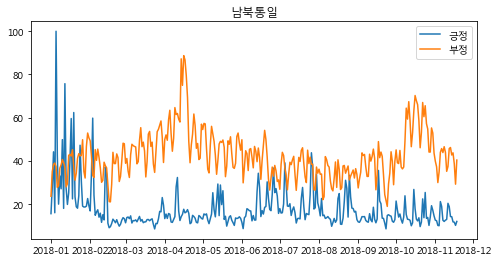

In [32]:
plt.figure(figsize=(8,4))
plt.plot(data1['날짜'], data1[data1.columns[1]], label='긍정')
plt.plot(data2['날짜'], data2[data2.columns[1]], label='부정')
plt.title(data1.columns[1])
plt.legend()
plt.show()

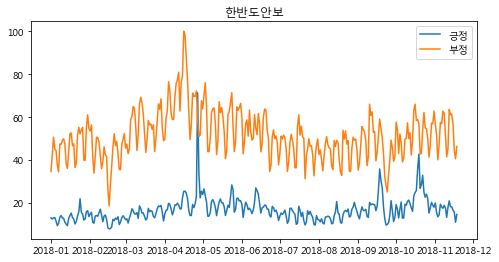

In [33]:
plt.figure(figsize=(8,4))
plt.plot(data1['날짜'], data1[data1.columns[3]], label='긍정')
plt.plot(data2['날짜'], data2[data2.columns[3]], label='부정')
plt.title(data1.columns[3])
plt.legend()
plt.show()

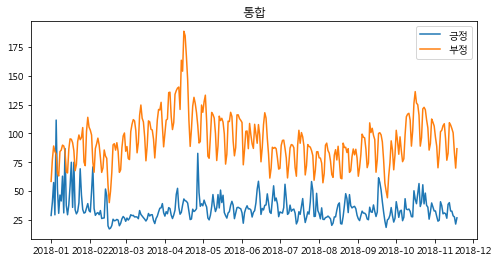

In [34]:
plt_1 = plt.figure(figsize=(8,4))
plt.plot(data1['날짜'], data1[data1.columns[4]], label='긍정')
plt.plot(data2['날짜'], data2[data2.columns[4]], label='부정')
plt.title(data1.columns[4])
plt.legend()
plt.show()

In [35]:
plt_1.savefig(r'./images/datalab_%s_1.png' %thema, format='png')

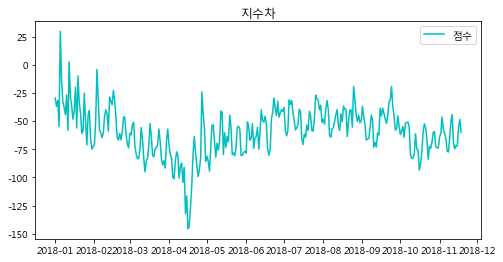

In [36]:
plt_2 = plt.figure(figsize=(8,4))
plt.plot(data1['날짜'], data1[data1.columns[5]], 'c', label='점수')
plt.title(data1.columns[5])
plt.legend()
plt.show()

In [37]:
plt_2.savefig(r'./images/datalab_%s_2.png' %thema, format='png')

In [38]:
data1.head()

,날짜,남북통일,날짜.1,한반도안보,통합,지수차
0,2018-01-01,15.61909,2018-01-01,13.13730,28.75639,-29.60791
1,2018-01-02,27.78527,2018-01-02,12.57081,40.35608,-36.96733
2,2018-01-03,44.21364,2018-01-03,13.13730,57.35094,-31.74446
3,2018-01-04,16.02373,2018-01-04,13.27218,29.29591,-54.96678
4,2018-01-05,100.00000,2018-01-05,11.59967,111.59967,29.69138


In [39]:
data1.to_csv('./TeamMission/datalab_%s_1_3.csv' %thema, sep=',', encoding='UTF-8')
print('./TeamMission/datalab_%s_1_3.csv 파일을 생성했습니다.')

./TeamMission/datalab_%s_1_3.csv 파일을 생성했습니다.


#### 지수차 그래프 그리기

In [40]:
data1 = pd.read_csv('./TeamMission/datalab_36_1_3.csv')
data2 = pd.read_csv('./TeamMission/datalab_37_1_3.csv')
data3 = pd.read_csv('./TeamMission/datalab_49_1_3.csv')

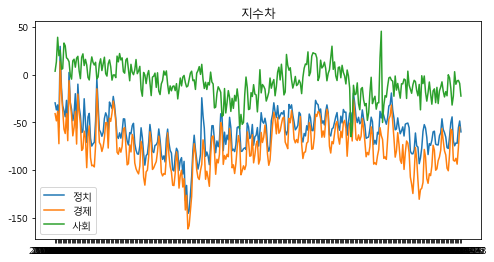

In [55]:
plt_3 = plt.figure(figsize=(8,4))
plt.plot(data1['날짜'], data1[data1.columns[6]], label='정치')
plt.plot(data2['날짜'], data2[data2.columns[6]], label='경제')
plt.plot(data3['날짜'], data3[data3.columns[6]], label='사회')
plt.title(data1.columns[6])
plt.legend()
plt.show()

In [56]:
plt_3.savefig(r'./images/datalab_%s_3.png' %thema, format='png')

### 점수화

##### 점수지표
- 청원 점수 : 25%
- 네이버랩 검색지수 : 25%
- 정량지표(목표달성도) : 50%

#### 청원 점수

In [43]:
len(president_36_3), len(president_37_3), len(president_49_3)

(20199, 17473, 22895)

In [44]:
sum_count_36, sum_count_37, sum_count_49

(3088617, 734551, 9391430)

#### 네이버랩 검색지수(평균)

In [45]:
round(sum(data1[data1.columns[6]]) / len(data1[data1.columns[6]]), 3), round(sum(data2[data2.columns[6]]) / len(data2[data2.columns[6]]),3), round(sum(data3[data3.columns[6]]) / len(data3[data3.columns[6]]), 3)

(-59.178, -75.999, -6.988)

#### 정량지표(목표달성도)

2018년 예산안 중 실제 이행예정 중이였던 정책들과
2018년도 실제 수행된 정책들을 비교해서 점수화

cf) 2018년 기획재정부 정책 예산안.pdf 참고

- 정치 : -10점
- 경제 : -30점
- 사회 : -20점

### 총평

정치 : 100 - (6.3 + 10.25 + 5)

경제 : 100 - (1.75 + 13.25 + 15)

사회 : 100 - (16.95 + 1.5 + 10)

In [50]:
100 - (6.3 + 10.25 + 5)

78.45

In [52]:
100 - (1.75 + 13.25 + 15)

70.0

In [53]:
100 - (16.95 + 1.5 + 10)

71.55

In [54]:
(78.45+70.0+71.55)/3

73.33333333333333

끝~